In [4]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from tqdm import tqdm

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [6]:
cuda = torch.cuda.is_available()

In [7]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
def convert_to_var(arr, astype='float32', add_dim=False):
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [9]:
class VAE(nn.Module):
    def __init__(self, input_shape=(-1, 10),
                 latent_dim=2, n_samples=10,
                 fc_size=1024, num_layers=2):
        super(VAE, self).__init__()
        self.n_samples = n_samples
        self.input_shape = input_shape
        
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_shape[-1], fc_size))
        for i in range(1,num_layers):
            encoder_layers.append(nn.Linear(fc_size//i, fc_size//(i+1)))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
            
        self.fc_mu = nn.Linear(fc_size//num_layers, latent_dim)
        self.fc_logvar = nn.Linear(fc_size//num_layers, latent_dim)
        
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, fc_size//num_layers))
        
        for i in range(num_layers-1):
            decoder_layers.append(nn.Linear(fc_size//(num_layers-i), fc_size//(num_layers-i-1)))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(fc_size, 2*input_shape[1]))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        enc_out = self.encoder(x)
        return self.fc_mu(enc_out), self.fc_logvar(enc_out)

    def reparameterize(self, mu, logvar):
        if self.training:
            n_samples = self.n_samples
            batch_size = mu.shape[0]
            latent_dim = mu.shape[1]
            eps = np.random.randn(batch_size*latent_dim*n_samples)\
                                 .reshape((batch_size, n_samples, latent_dim))
            eps = convert_to_var(eps)
            std = logvar.mul(0.5).exp_()
            mu = mu.view(-1, 1, latent_dim)
            std = std.view(-1, 1, latent_dim)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        dec_out = self.decoder(z)
        if len(dec_out.shape) == 3:
            dec_out = dec_out.view(-1, self.n_samples, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)
            recon_x = probs[:,:,:,1]
        else:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)   
            recon_x = probs[:,:,1]
        return recon_x, log_probs

    
    def forward(self, x):
        mu, logvar = self.encode(x.view(self.input_shape))
        z = self.reparameterize(mu, logvar)
        recon_x, log_probs = self.decode(z)
        return recon_x, log_probs, mu, logvar

In [10]:
def loss_function(log_probs, x, mu, logvar, n_samples=10):
    KLD = 0.5 * torch.mean(
                      torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar, dim=1))
    
    if len(log_probs.shape)==4:
        x = x.view(-1, 1, x.shape[1]).clone()
        x = x.repeat(1, n_samples, 1)
        LL = torch.sum((1-x)*log_probs[:,:,:,0] + x * log_probs[:,:,:,1]) / (x.shape[0]*n_samples)
    else:
        LL = torch.sum((1-x)*log_probs[:,:,0] + x * log_probs[:,:,1]) / (x.shape[0])

    elbo = LL - KLD
    loss = -1 * elbo
    return  loss, LL, KLD

In [11]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [12]:
log_interval = 10

def train_epoch(model, optimizer, X_adversarial=None, batchsize=32):
    loss_log = []
    ll_log = []
    kld_log = []
        
    for x_batch in iterate_minibatches(X_train, batchsize=batchsize, shuffle=True):
        model.train()
        data = convert_to_var(x_batch.astype(np.float32))
        optimizer.zero_grad()
        recon_batch, log_probs, mu, logvar = model(data)
        loss, ll, kld = loss_function(log_probs, data, mu, logvar, model.n_samples)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.data[0])
        ll_log.append(ll.data[0])
        kld_log.append(kld.data[0])
        
    return loss_log, ll_log, kld_log

In [13]:
def train(model, optimizer, num_epochs=5, batchsize=32):
    loss_log = []
    ll_log = []
    kld_log = []
    
    for i in range(num_epochs):
        epoch_results = train_epoch(model, optimizer, batchsize=32)    
        loss_log += epoch_results[0]
        ll_log += epoch_results[1]
        kld_log += epoch_results[2]
        
    return loss_log, ll_log, kld_log

In [14]:
def plot_learning_history(logs, filename=None):
    
    loss_log, ll_log, kld_log = logs
    
    plt.figure(figsize=(20, 7))
    linewidth = 4
    
    plt.subplot(1, 3, 1)
    plt.plot(loss_log)
    plt.title('Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(ll_log)
    plt.title('LL')
    
    plt.subplot(1, 3, 3)
    plt.plot(kld_log)
    plt.title('KL')
    
    plt.grid()
    
    if filename is not None:
        plt.savefig(filename)

In [15]:
dim=50
num_classes = 5

In [16]:
def get_one_hot_object(obj_class, dim, num_classes):
    x = np.zeros(dim)
    x[:(dim//num_classes) * (obj_class+1)] = 1
    return x

In [17]:
X_train = []
num_per_class = 250
for i in range(num_classes):
    for j in range(num_per_class):
        X_train.append(get_one_hot_object(i,
                                          dim, num_classes))
X_train = np.array(X_train)

In [18]:
X_train.shape

(1250, 50)

In [19]:
%%time
model = VAE(latent_dim=2, input_shape=(-1,dim), n_samples=25, fc_size=1024, num_layers=2)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_logs = train(model, optimizer, num_epochs=20, batchsize=128)
clear_output()

CPU times: user 2min 20s, sys: 1.02 s, total: 2min 21s
Wall time: 1min 1s


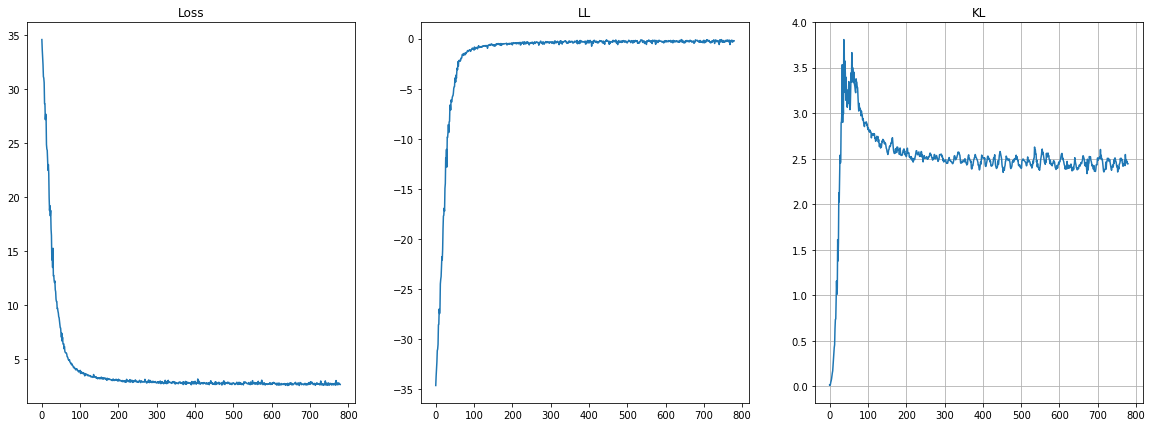

In [20]:
plot_learning_history(train_logs)

In [23]:
train_logs[1][-10:]

[-0.3764525353908539,
 -0.23619674146175385,
 -0.17904537916183472,
 -0.15854614973068237,
 -0.24855898320674896,
 -0.3647572994232178,
 -0.20509564876556396,
 -0.27753278613090515,
 -0.2286672741174698,
 -0.22529220581054688]

In [25]:
X_test = []
for i in range(num_classes):
    X_test.append(get_one_hot_object(i, dim, num_classes))
X_test = np.array(X_test)

In [26]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

In [27]:
X_test.shape

(5, 50)

In [28]:
X_test.sum(axis=1)

array([10., 20., 30., 40., 50.])

In [29]:
recon_batch.sum(axis=1)

array([10.002638, 20.00008 , 30.00032 , 39.99957 , 49.995537],
      dtype=float32)

In [30]:
mu

array([[ 1.202409  , -0.93047804],
       [-0.55830276, -1.2569444 ],
       [-1.1083344 , -0.02398759],
       [-0.6735633 ,  1.1210134 ],
       [ 1.073112  ,  1.1672846 ]], dtype=float32)

In [31]:
std

array([[0.32127723, 0.33232784],
       [0.3161205 , 0.30540296],
       [0.45778757, 0.16606554],
       [0.31963092, 0.27526444],
       [0.33318463, 0.3226459 ]], dtype=float32)

In [32]:
from matplotlib.patches import Ellipse

colors = ['red', 'green', 'blue', 'orange', 'pink']
def plot_point_with_std(mu, std):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, aspect='equal')

    e = Ellipse([0,0], 6, 6)
    e.set_alpha(0.75)
    e.set_facecolor('white')
    e.set_edgecolor('black')
    ax.add_artist(e)

    
    for i in range(len(mu)):
        e = Ellipse(mu[i], 6*std[i][0], 6*std[i][1])
        e.set_alpha(0.25)
        e.set_facecolor('gray')
        ax.add_artist(e)

        plt.plot(mu[i][0], mu[i][1], '.', markersize=15,
                 color=colors[i], alpha=0.8)
    plt.grid()
    plt.title('title')
    plt.xlim((-4,4))
    plt.ylim((-4,4))

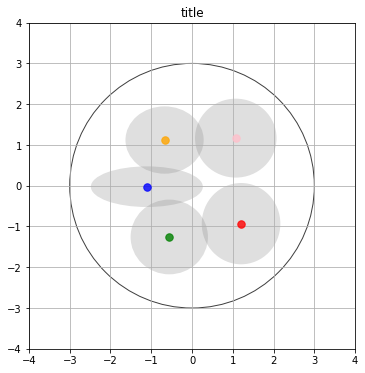

In [33]:
plot_point_with_std(mu, std)

# Онлайн-обучение

### Стационарные данные

In [34]:
X_test.shape

(5, 50)

In [35]:
def get_pseudo_count_from_pg(pg, damp_coef):
    eps = 1e-4
    t = np.exp(max(damp_coef * pg, eps)) - 1
    pseudo_count = 1 / t
    
    return pseudo_count

In [36]:
def get_pseudo_count_from_probs(p0, p1):
    eps = 1e-3
    pseudo_count = p0 * (1 - p1) / max(p1 - p0, eps)
    
    return pseudo_count

In [37]:
def get_obj_log_prob(model, obj, return_loss=False):
    x = np.array([obj])
    probs, log_probs, mu, logvar = model(convert_to_var(x))
    
    if return_loss:
        loss, ll, kld = loss_function(log_probs, convert_to_var(x), mu, logvar, model.n_samples)

    log_probs = log_probs.data.numpy()[0].mean(axis=0)
    log_probs = log_probs[np.arange(dim), obj.astype('int64')]
    obj_log_prob = log_probs.sum()

    if return_loss:
        return obj_log_prob, loss, ll, kld
    else:
        return obj_log_prob

In [43]:
def plot_different_pgs():

    filtered_pgs_by_sq_n = [[] for _ in range(num_classes)]
    filtered_pgs_by_n = [[] for _ in range(num_classes)]
    filtered_pgs = [[] for _ in range(num_classes)]


    for i in range(len(chosen_classes)):
        cur_class = chosen_classes[i]
        filtered_pgs[cur_class].append( pgs[i] )
        filtered_pgs_by_n[cur_class].append( pgs[i]/(i+1) )
        filtered_pgs_by_sq_n[cur_class].append( pgs[i]/np.sqrt((i+1)) )

    filtered = [filtered_pgs, filtered_pgs_by_sq_n, filtered_pgs_by_n]
    names = ['PG_n', 'PG_n / sqrt(n)', 'PG_n / n']
    y_limits = [(-2, 10), (-0.1, 0.5), (-0.05,0.1)]

    plt.figure(figsize=(25,15))
    for j in range(len(filtered)):
        for i in range(num_classes):
            plt.subplot(3,5,5*j+i+1)
            plt.plot(filtered[j][i], label='class {}'.format(i+1))
            plt.axhline(y=0, color='red')

            plt.grid()
            plt.title(names[j], fontsize=20)
            plt.ylim(y_limits[j])
            plt.legend(loc='upper right', fontsize=15)

In [42]:
def plot_pgs(chosen_classes, pgs, filename=None):
    filtered_pgs = [[] for _ in range(num_classes)]

    for i in range(len(chosen_classes)):
        cur_class = chosen_classes[i]
        filtered_pgs[cur_class].append( pgs[i] )

    plt.figure(figsize=(25,5))
    for i in range(num_classes):
        plt.subplot(1,5,i+1)
        plt.plot(filtered_pgs[i], label='class {}'.format(i+1))
        plt.axhline(y=0, color='red')

        plt.grid()
        plt.title('PG', fontsize=20)
        plt.ylim(-0.5, 5)
        plt.legend(loc='upper right', fontsize=15)
    
    if filename is not None:
        plt.savefig(filename)

In [44]:
def run(run_iter, fc_size=1024, num_layers=2,
       lr=0.0001, momentum=0.9, weight_decay=0.5, eps=1e-4, centered=False,
       img_name='test', filename='params'):
    
    np.random.seed(42)

    model = VAE(latent_dim=2, input_shape=(-1, dim),
                n_samples=25, fc_size=fc_size, num_layers=num_layers)

    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum,
                              weight_decay=weight_decay, eps=eps, centered=centered)


    real_counters = [[0] for _ in range(num_classes)]

    steps = []
    chosen_classes = []
    pgs = []

    pseudo_counters = [[0] for _ in range(num_classes)]

    train_logs = [[] for _ in range(3)]

    num_steps = int(2*1e+3)
    
    #periods = 4
    #period_len = num_steps // 4

    for t in range(num_steps):
        cur_class = np.random.randint(low=0, high=5)            
        obj = get_one_hot_object(cur_class, dim, num_classes)


        log_prob_before, loss, ll, kld = get_obj_log_prob(model, obj, return_loss=True)

        train_logs[0].append(loss.data.numpy()[0])
        train_logs[1].append(ll.data.numpy()[0])
        train_logs[2].append(kld.data.numpy()[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        log_prob_after = get_obj_log_prob(model, obj, return_loss=False)

        #log_prob_before = np.log(real_counters[cur_class][-1] / (t+1))
        #log_prob_after  = np.log((real_counters[cur_class][-1]+1) / (t+2))

        pg = log_prob_after - log_prob_before
        pseudo_counter = get_pseudo_count_from_pg(pg, damp_coef=1/np.sqrt(t+1))

        chosen_classes.append(cur_class)
        pgs.append(pg)
        steps.append(t+1)

        for i in range(num_classes):
            if i == cur_class:
                real_counters[i].append(real_counters[i][-1] + 1)
            else:
                real_counters[i].append(real_counters[i][-1])
                
    plot_learning_history(train_logs, filename=img_name+'_logs.jpg')
    plot_pgs(chosen_classes, pgs, filename=img_name+'_pgs.jpg')
    
    if filename is not None:
        with open(filename, 'a') as f:
            negative_pgs_pct = int(100 * (np.array(pgs) < 0).mean() )
            description = [run_iter,
                           np.max(train_logs[1][-10:]), negative_pgs_pct,
                           fc_size, num_layers,
                           lr, momentum, weight_decay, eps, centered]
            description = [str(t) for t in description]
            s = ','.join(description) + '\n'
            f.write(s)
            
            
    return steps, chosen_classes, pgs, real_counters 

In [45]:
from sklearn.model_selection import ParameterGrid

In [46]:
d = {'fc_size': [512, 1024, 2048], 'num_layers': [2, 3, 4, 5],
     'lr': [5*1e-4, 1e-4, 5*1e-5, 1e-5],
      'momentum': [0, 0.1, 0.25, 0.5, 0.75, 0.9],
      'eps': [1e-4, 1e-6, 1e-8], 
      'centered': [True, False]}

In [47]:
grid = ParameterGrid(d)

In [ ]:
%%time

with open('params', 'w') as f:
    pass

for i, params in enumerate(grid):
    try:
        run(i+1,
            **params,
            img_name='imgs/{}'.format(i+1), filename='params')
    except:
        pass
    clear_output()

In [108]:
probs, log_probs, mu, logvar = model(convert_to_var(X_test))

In [109]:
probs = probs.data.numpy().mean(axis=1)
log_probs = log_probs.data.numpy().mean(axis=1)
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

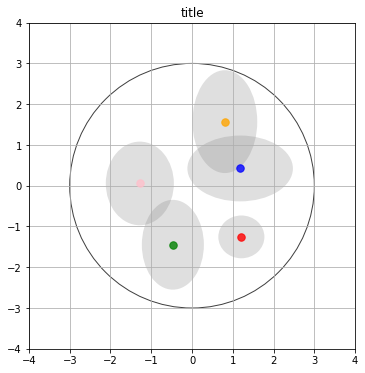

In [110]:
plot_point_with_std(mu, std)

In [111]:
pseudo_counts = [[] for _ in range(num_classes)]
damped_pgs_by_classes = [[] for _ in range(num_classes)]

for i in range(len(steps)):
    cl = chosen_classes[i]
    pg = pgs[i]
    t = steps[i]
    
    damp_coef=1/t
    pseudo_count = get_pseudo_count_from_pg(pg, damp_coef=damp_coef)
    
    
    
    
    for j in range(num_classes):
        if j == cl:
            pseudo_counts[j].append(pseudo_count)
            damped_pgs_by_classes[j].append(damp_coef*pg)


In [112]:
for i in range(len(pseudo_counts[0])):
    print(pseudo_counts[0][i], damped_pgs_by_classes[0][i])

0.10436154707492531 2.359161376953125
0.5852604887658011 0.9964469909667969
0.2342496975546194 1.6618309020996094
1.1238117836152384 0.6364862001859225
1.752270482909172 0.45151383536202566
2.0409319893171287 0.3987574828298468
0.027395125563040315 3.6244167751736107
9999.500008329007 -0.16316273337916323
9999.500008329007 -0.32477814111954123
0.9811732191701109 0.7026954650878907
8.630464255139243 0.10963313475899074
63.43659025057823 0.015640815099080402
9999.500008329007 -0.014132461547851563
112.87388094432133 0.008820430905211205
287.76264489622423 0.003469062053551108
68.27946129522076 0.014539480209350586
28.085728674147465 0.0349860593497035
129.7455298893296 0.007677844401155965
46.947656181398116 0.021076636844211155
90.48430697474461 0.01099101702372233
79.25954570614171 0.012537848490935106
344.2548435251601 0.002900613928740879
243.84839518774734 0.004092522870714419
1966.3170778846534 0.0005084357019198143
9999.500008329007 -0.0005386664172795814
797.5618133283455 0.00125

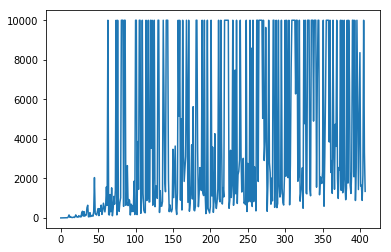

In [291]:
plt.plot(pseudo_counts[0])

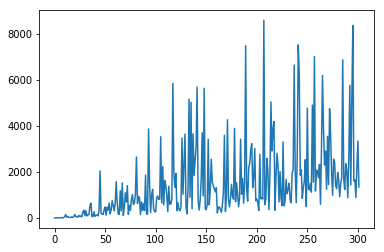

In [292]:
plt.plot([t for t in pseudo_counts[0] if t < 9000])

In [250]:
def plot_counters(real_counters, pseudo_counters):
    plt.figure(figsize=(10,10))
    
    n = len(real_counters[0])

    plt.subplot(211)
    plt.plot(np.arange(n), real_counters[0], label='Frequent event (class: 0)')
    plt.plot(np.arange(n), real_counters[3], label='Rare event (class: 3)')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Real counters', fontsize=20)
    
    plt.subplot(212)
    plt.plot(np.arange(n), pseudo_counters[0], label='Frequent event (class: 0)')
    plt.plot(np.arange(n), pseudo_counters[3], label='Rare event (class: 3)')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Pseudo counters', fontsize=20)

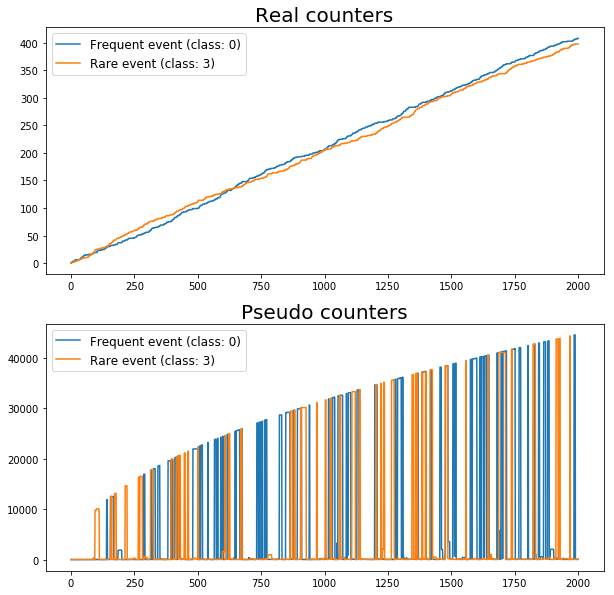

In [240]:
plot_counters(real_counters, pseudo_counters)

In [252]:
len(filtered_pgs[0])

408

In [253]:
len(pseudo_counters[0])

409

In [256]:
pseudo_counters = pseudo_counters[1:]

In [257]:
for i in range(len(pseudo_counters[0])):
    print(filtered_pgs[0][i], pseudo_counters[0][i])

7.4889565 0
3.2644653 0.011916820269922619
6.9532223 0.43499734565710346
2.3865566 1.2969575585070319
4.775902 1.3405957349235837
2.8126736 1.2590559565966601
7.856489 5.684517799125778
7.2666836 2.7576116557583448
2.802123 1.3971425486534021
3.1157594 3.2056519384290105
0.804337 1.8223081630177766
-0.6088877 1.6079419461752442
1.720613 1.3675922657240915
0.72906494 4.733215946905066
2.646449 2.9845116409961268
2.4326525 7745.466703178131
5.518812 7.100359873087631
0.9866328 19.286822149362226
2.5297155 1.5558832549871997
1.1085882 4.487702489573989
1.4464054 1.6819052524808198
3.2398925 0.25641481597634724
0.5136485 10439.806516898467
0.4465189 7.859699306754392
5.9364305 6.157471281142853
1.1045532 156.081288273424
2.7039595 12.172247359604954
0.8273468 7.511231393068769
1.9757869 4.596352651957721
0.51490366 7.198169127636115
0.6189418 38.178441155349894
0.9116113 14.01185054166773
1.1749573 10.225247693746168
1.2720604 8.205535091775014
0.13769436 1589.6415513855413
0.5906563 3.252

In [347]:
pgs[3]

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,


In [349]:
t = [pseudo_counters[3][i] for i in range(len(pseudo_counters[3])) if pseudo_counters[3][i] != -1]

In [350]:
t

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
